## Imports

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from numba import njit
import time

##  Navier Stokes Equation

## Pure python

In [2]:
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
    row, col = p.shape
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
              (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

def pressure_poisson_numba(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = np.copy()
    #fill the update of p
    for q in range(nit):
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
    
    #fill the update of u and v
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-un[1:-1, 1:-1] * dt / dx *(un[1:-1, 1:-1] - un[1:-1, 0:-2]) -vn[1:-1, 1:-1] * dt / dy *(un[1:-1, 1:-1] - un[0:-2, 1:-1]) -dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +dt / dy**2 *(un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return u, v, p

## Numba accelerator

In [3]:
from numba import njit
@njit(fastmath=True)
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    row, col = p.shape
    #fill the update of b
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
              (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    return b

def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = np.copy()
    
    #fill the update of p
    for q in range(nit):
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

    p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
    p[-1, :] = 0        # p = 0 at y = 2
        
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
    u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

    v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    return u, v, p
        
        
    return u, v, p

## Inputs

/tmp/ipykernel_3426/3125187800.py:34: RuntimeWarning: overflow encountered in multiply
  u[1:-1, 1:-1] = (un[1:-1, 1:-1]-un[1:-1, 1:-1] * dt / dx *(un[1:-1, 1:-1] - un[1:-1, 0:-2]) -vn[1:-1, 1:-1] * dt / dy *(un[1:-1, 1:-1] - un[0:-2, 1:-1]) -dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +nu * (dt / dx**2 *
/tmp/ipykernel_3426/70601161.py:26: UserWarning: No contour levels were found within the data range.
  pyplot.contour(X, Y, p, cmap=cm.viridis)


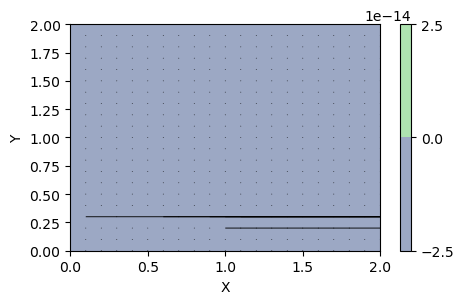

In [4]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

/tmp/ipykernel_3426/3382859310.py:4: UserWarning: No contour levels were found within the data range.
  pyplot.contour(X, Y, p, cmap=cm.viridis)
/home/no/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


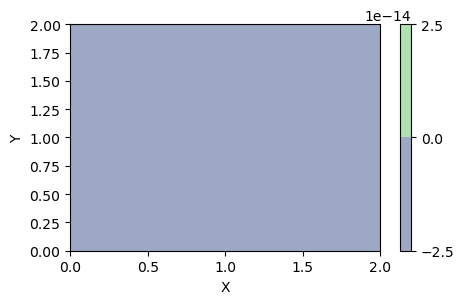

In [5]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

## Call Funtions

## Pure python function

In [6]:
%timeit cavity_flow_pure(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

/tmp/ipykernel_3426/962304014.py:38: RuntimeWarning: overflow encountered in multiply
  un[1:-1, 1:-1] * dt / dx *
/tmp/ipykernel_3426/962304014.py:44: RuntimeWarning: overflow encountered in multiply
  (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
/tmp/ipykernel_3426/962304014.py:46: RuntimeWarning: overflow encountered in multiply
  (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
/tmp/ipykernel_3426/962304014.py:37: RuntimeWarning: invalid value encountered in add
  u[1:-1, 1:-1] = (un[1:-1, 1:-1]-


441 µs ± 5.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Numba accelerator

In [7]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

/tmp/ipykernel_3426/3125187800.py:34: RuntimeWarning: overflow encountered in multiply
  u[1:-1, 1:-1] = (un[1:-1, 1:-1]-un[1:-1, 1:-1] * dt / dx *(un[1:-1, 1:-1] - un[1:-1, 0:-2]) -vn[1:-1, 1:-1] * dt / dy *(un[1:-1, 1:-1] - un[0:-2, 1:-1]) -dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +nu * (dt / dx**2 *
/tmp/ipykernel_3426/3125187800.py:35: RuntimeWarning: overflow encountered in multiply
  (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +dt / dy**2 *(un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
/tmp/ipykernel_3426/3125187800.py:34: RuntimeWarning: invalid value encountered in add
  u[1:-1, 1:-1] = (un[1:-1, 1:-1]-un[1:-1, 1:-1] * dt / dx *(un[1:-1, 1:-1] - un[1:-1, 0:-2]) -vn[1:-1, 1:-1] * dt / dy *(un[1:-1, 1:-1] - un[0:-2, 1:-1]) -dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +nu * (dt / dx**2 *


424 µs ± 9.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
